# ***Project - Unplanned stops prediction***

In [2]:
import arviz as az
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from cmdstanpy import CmdStanModel

# GLOBAL CONSTANTS
SEED = 29042020
REFRESH = 1000

C:\Users\gcyburt\AppData\Roaming\Python\Python311\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data overview

Data used to this project came from the factory's MES system in form of three csv files that contain information about production counters, line's states during production runtime and produced items' cycle times for March, April, July and August.

### States

States' data consists of 4 columns: state id, start time, end time and state tag (can be RUN, MICROSTOP, UNPLANNED STOP and many more). Data is filtered so it contains only RUN state and unscheduled stoppages.

In [113]:
states=pd.read_csv('states.csv',delimiter=';')
states_map={'RUN': 1}
states.head()

,id,time_from,time_to,tag
0,6312581,2022-03-04 09:18:19 +01:00,2022-03-04 09:18:48 +01:00,RUN
1,6312619,2022-03-04 09:20:04 +01:00,2022-03-04 09:20:41 +01:00,RUN
2,6312655,2022-03-04 09:21:51 +01:00,2022-03-04 09:23:02 +01:00,RUN
3,6313787,2022-03-04 09:30:17 +01:00,2022-03-04 10:25:31 +01:00,RUN
4,6313869,2022-03-04 10:27:54 +01:00,2022-03-04 10:28:13 +01:00,RUN


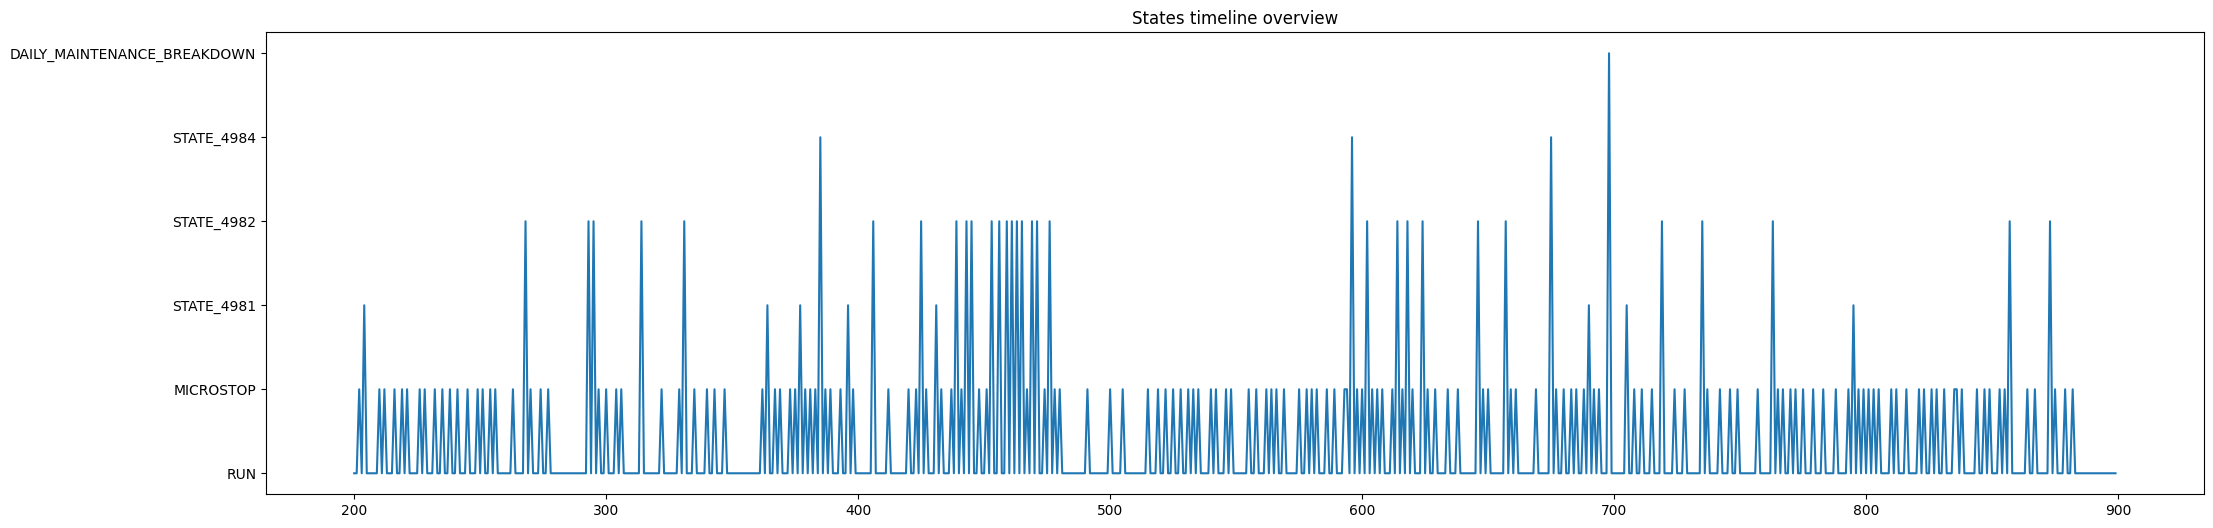

In [112]:
plt.figure(figsize=(25, 6))
plt.title('States timeline overview')
plt.plot(states['tag'][200:900])


### Counters

Counters table contains information about production quantity grouped by production hours, there are two types of counters:
   - PRODUCTION (amount of good pieces)
   - REJECT (production waste)

In [59]:
counters=pd.read_csv('counters.csv',delimiter=';')
counters.head()

,id,value,prod_hour,tag
0,30738538,54.000,2022-03-04 09:00:00 +01:00,PRODUCTION
1,30739005,50.333,2022-03-04 09:00:00 +01:00,REJECT
2,30738341,33.000,2022-03-04 09:00:00 +01:00,PRODUCTION
3,30739158,36.333,2022-03-04 09:00:00 +01:00,REJECT
4,30738658,60.000,2022-03-04 09:00:00 +01:00,PRODUCTION


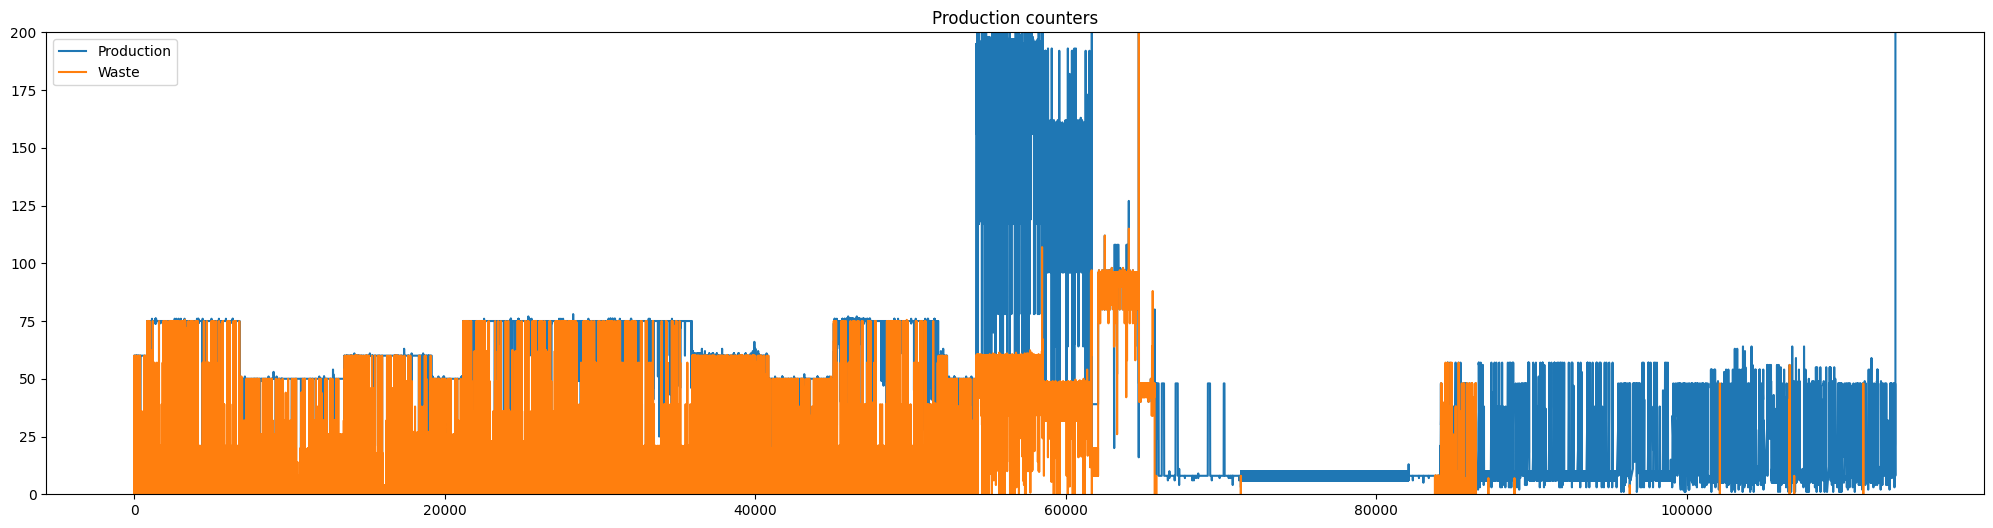

In [95]:
plt.figure(figsize=(25, 6))
plt.title('Production counters')
plt.plot((counters.loc[counters['tag']=='PRODUCTION'])['value'], label='Production')
plt.plot((counters.loc[counters['tag']=='REJECT'])['value'], label='Waste')
plt.ylim([0, 200])
plt.legend()

### Cycle times

Third file stores information about items' cycle times from which target speed can be calculated simply. Production orders' duration is provided here as well.

In [60]:
cycle_times=pd.read_csv('cycle_times.csv',delimiter=';')
cycle_times.head()

,start_time,end_time,cycle_time_s
0,2022-03-04 20:20:20 +01:00,2022-03-06 17:58:55 +01:00,0.8
1,2022-03-06 17:59:33 +01:00,2022-03-07 05:31:12 +01:00,0.8
2,2022-03-07 09:35:57 +01:00,2022-03-08 03:33:14 +01:00,1.2
3,2022-03-08 05:30:54 +01:00,2022-03-08 06:18:19 +01:00,1.2
4,2022-03-08 06:18:56 +01:00,2022-03-09 07:16:36 +01:00,1.2


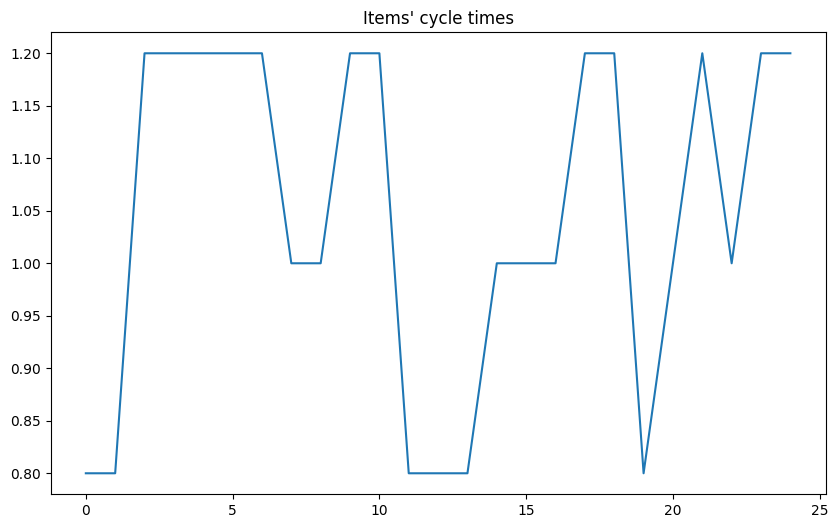

In [114]:
plt.figure(figsize=(10, 6))
plt.title('Items\' cycle times')
plt.plot(cycle_times['cycle_time_s'])

## Task 1. Prior predictive checks

In [3]:
model_ppc = CmdStanModel(stan_file="unplanned_stops_ppc.stan")

18:17:54 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_ppc.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_ppc.exe
18:18:39 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_ppc.exe


In [5]:
mu_mu, mu_sig, sig_lbd = 0.07, 0.03, 15
sim = model_ppc.sample(data={"mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}, iter_sampling=REFRESH, iter_warmup=0, chains=1, fixed_param=True, seed=SEED, refresh=REFRESH)

18:18:56 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


18:18:56 - cmdstanpy - INFO - CmdStan done processing.


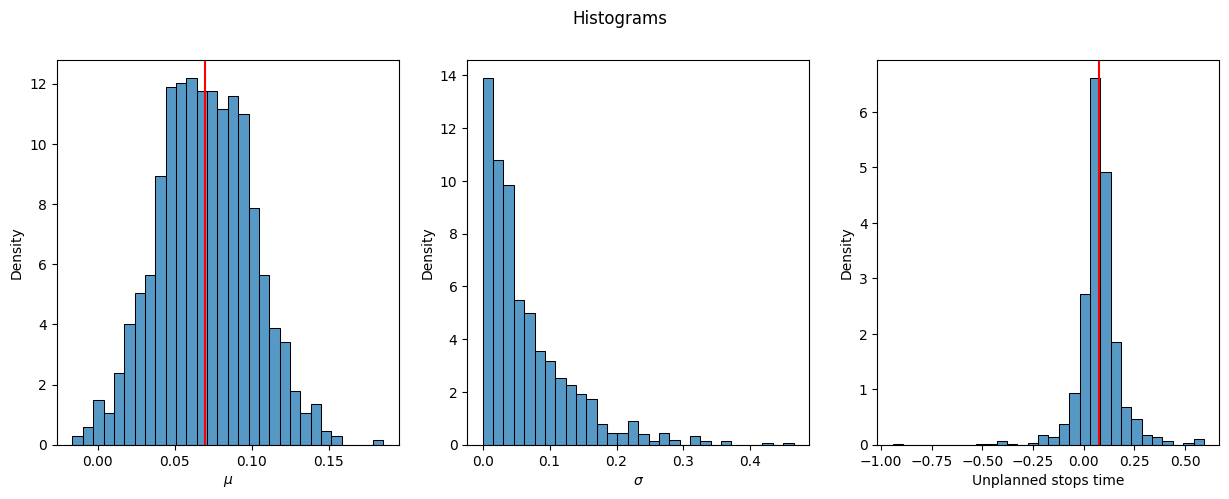

In [6]:
sim_pd = sim.draws_pd()

_, ax = plt.subplots(1, 3, figsize=(15, 5))
sns.histplot(data=sim_pd, x="mu", stat="density", ax=ax[0], bins=30)
sns.histplot(data=sim_pd, x="sig", stat="density", ax=ax[1], bins=30)
sns.histplot(data=sim_pd, x="unplanned_stops_time", stat="density", ax=ax[2], bins=30)
ax[0].axvline(np.mean(sim_pd.mu), color="red")
ax[2].axvline(np.mean(sim_pd.unplanned_stops_time), color="red")
ax[0].set_xlabel("$\mu$")
ax[1].set_xlabel("$\sigma$")
ax[2].set_xlabel("Unplanned stops time")
plt.suptitle("Histograms")
plt.show()

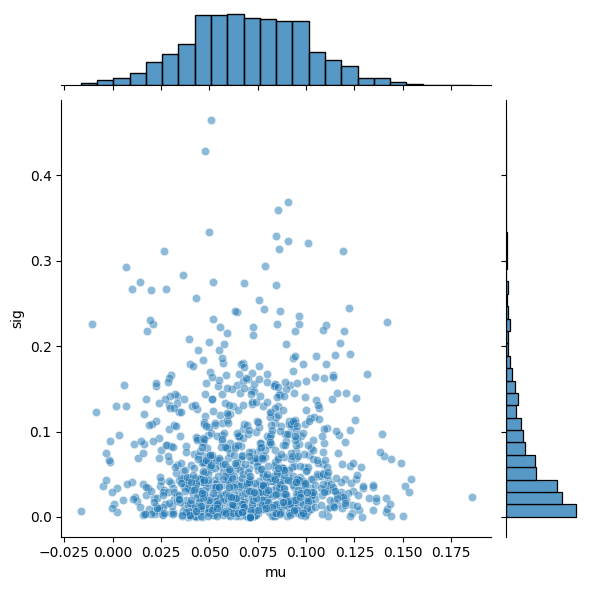

In [7]:
sns.jointplot(data=sim_pd, x="mu", y="sig", alpha=0.5)
plt.show()

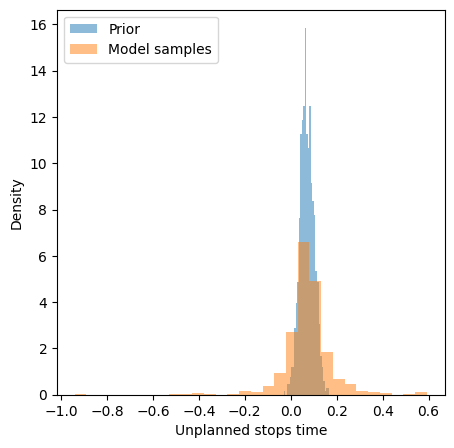

In [8]:
unplanned_stops_time_prior = np.random.normal(mu_mu, mu_sig, size=REFRESH)

plt.figure(figsize=(5, 5))
plt.hist(unplanned_stops_time_prior, bins=30, alpha=0.5, density=True, label="Prior")
plt.hist(sim_pd.unplanned_stops_time, bins=30, alpha=0.5, density=True, label="Model samples")
plt.xlabel("Unplanned stops time"), plt.ylabel("Density")
plt.legend()
plt.show()

**Observed data is possible to obtain using priors.**

## Task 2. Model fit and evaluation

In [9]:
model_1_fit = CmdStanModel(stan_file="unplanned_stops_fit.stan")

18:19:33 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_fit.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_fit.exe
18:20:09 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_fit.exe
18:20:09 - cmdstanpy - WARNING - Stan compiler has produced 1 warnings:
18:20:09 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.hpp C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.stan
Warning in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a 

In [11]:
d = {1: (7968.0, 44961.0, 0.1505412911636343), 2: (14384.0, 71881.0, 0.166742015881296), 3: (13531.0, 70913.0, 0.1602363696651035), 4: (4733.0, 80329.0, 0.0556417671815852), 5: (6952.0, 64399.0, 0.09743381312104946), 6: (2202.0, 58017.0, 0.03656653215762467), 7: (13062.0, 69685.0, 0.1578546654259369), 8: (5012.0, 64881.0, 0.0717096132659923), 9: (16624.0, 64370.0, 0.20524977158801885), 10: (10239.0, 69686.0, 0.12810760087582107), 11: (5204.0, 79832.0, 0.0611976104238205), 12: (4097.0, 81941.0, 0.04761849415374602), 13: (13528.0, 64222.0, 0.1739935691318328), 14: (19960.0, 65099.0, 0.23466064731539285), 15: (6200.0, 74064.0, 0.07724509119904316), 16: (19888.0, 65828.0, 0.23202202622614215), 17: (28331.0, 54086.0, 0.34375189584673066), 18: (37628.0, 46757.0, 0.4459086330508977), 19: (590.0, 62994.0, 0.009279063915450428), 20: (4993.0, 66478.0, 0.06986050286130038), 21: (6284.0, 77671.0, 0.07484962182121374), 22: (12181.0, 65560.0, 0.1566869476852626), 23: (13449.0, 64831.0, 0.17180633622892183), 24: (7112.0, 75595.0, 0.08599030311823666), 25: (6737.0, 69267.0, 0.08864007157518025), 26: (1461.0, 56719.0, 0.02511172224132004), 27: (0.0, 43200.0, 0.0), 28: (0.0, 43200.0, 0.0), 29: (0.0, 43200.0, 0.0), 30: (25587.0, 42326.0, 0.37676144478965734), 31: (39779.0, 46340.0, 0.4619073607450156), 32: (43150.0, 43235.0, 0.499508016438039), 33: (27072.0, 59321.0, 0.3133587211926892), 34: (23075.0, 38101.0, 0.3771904014646266), 35: (0.0, 43200.0, 0.0), 36: (0.0, 43200.0, 0.0), 37: (16148.0, 52217.0, 0.23620273531777958), 38: (42910.0, 43211.0, 0.4982524587498984)}

In [12]:
fit = model_1_fit.sample(data={"N": len(d), "unplanned_stops_times": [v[2] for v in d.values()], "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}, seed=SEED)

18:21:37 - cmdstanpy - INFO - CmdStan start processing
chain 1 |          | 00:00 Status



chain 1 |▍         | 00:00 Status
chain 1 |████████▋ | 00:00 Iteration: 1600 / 2000 [ 80%]  (Sampling)



chain 1 |██████████| 00:00 Sampling completed                       
chain 2 |██████████| 00:00 Sampling completed                       
chain 3 |██████████| 00:00 Sampling completed                       
chain 4 |██████████| 00:00 Sampling completed                       


18:21:38 - cmdstanpy - INFO - CmdStan done processing.
18:21:38 - cmdstanpy - WARNING - Non-fatal error during sampling:
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.stan', line 19, column 2 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.stan', line 19, column 2 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.stan', line 19, column 2 to column 42)
Exception: normal_lpdf: Scale parameter is 0, but must be positive! (in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_fit.stan', line 19, column 2 to column 42)
Consider re-running with show_

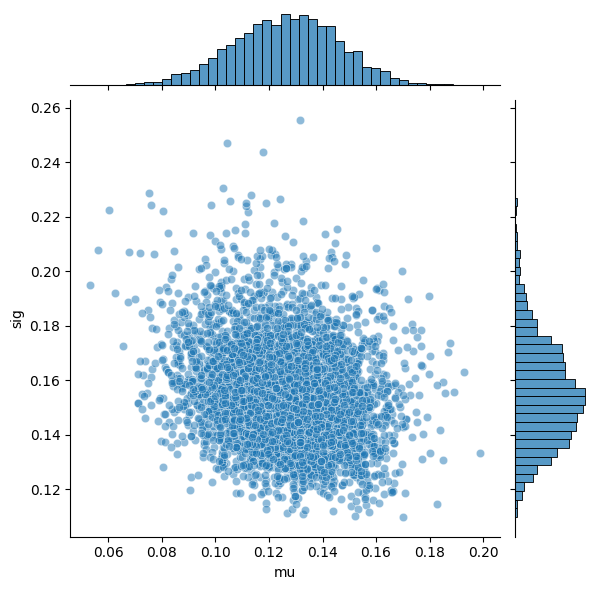

In [13]:
fit_pd = fit.draws_pd()

sns.jointplot(data=fit_pd, x="mu", y="sig", alpha=0.5)
plt.show()

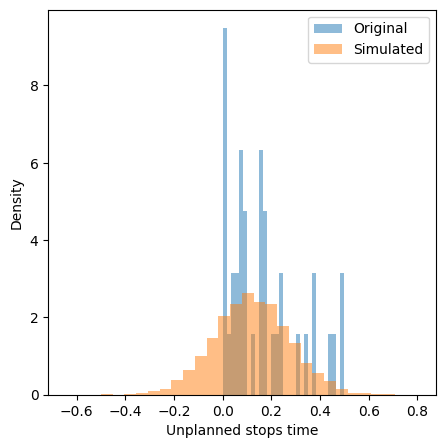

In [14]:
plt.figure(figsize=(5, 5))
plt.hist([v[2] for v in d.values()], bins=30, alpha=0.5, density=True, label="Original")
plt.hist(fit_pd.unplanned_stops_time, bins=30, alpha=0.5, density=True, label="Simulated")
plt.xlabel("Unplanned stops time"), plt.ylabel("Density")
plt.legend()
plt.show()

**The model fits the data pretty well.**

## Task 3. Adding predictor to the model - weight

In [15]:
d_counters = {1: 33976.166, 2: 90821.5, 3: 88954.0, 4: 63257.5, 5: 58983.0, 6: 65500.0, 7: 68684.0, 8: 71998.0, 9: 52207.0, 10: 65215.0, 11: 97578.0, 12: 88997.0, 13: 91188.5, 14: 73650.0, 15: 97675.5, 16: 63757.828, 17: 49584.667, 18: 42497.331000000006, 19: 7736.6669999999995, 20: 32457.0, 21: 58604.0, 22: 59863.5, 23: 85037.0, 24: 95689.5, 25: 54456.0, 26: 15356.0, 27: 0.0, 28: 0.0, 29: 0.0, 30: 0.0, 31: 0.0, 32: 0.0, 33: 157475.647, 34: 122475.64000000001, 35: 0.0, 36: 84875.658, 37: 116671.98, 38: 3734.0}
d_counters_array = np.array(list(d_counters.values()))
d_counters_norm = (d_counters_array - d_counters_array.mean()) / d_counters_array.std()
weight_counters = np.linspace(d_counters_norm.min(), d_counters_norm.max(), num=len(d))
weight_counters = np.linspace(0, 0, num=len(d))

d_cycles = {1: 0.9, 2: 0.9, 3: 0.8, 4: 1.2, 5: 1.2, 6: 1.2, 7: 1.0, 8: 1.0, 9: 1.2, 10: 0.8, 11: 0.8, 12: 0.8, 13: 0.8, 14: 0.8, 15: 0.8, 16: 1.0, 17: 1.0, 18: 1.0, 19: 1.2, 20: 1.2, 21: 1.2, 22: 0.8, 23: 0.8, 24: 0.8, 25: 1.1, 26: 1.1, 27: 1.1, 28: 1.1, 29: 1.1, 30: 1.1, 31: 1.1, 32: 1.1, 33: 1.0, 34: 1.0, 35: 1.0, 36: 1.0, 37: 1.2, 38: 1.2}
d_cycles_array = np.array(list(d_cycles.values()))
d_cycles_norm = (d_cycles_array - d_cycles_array.mean()) / d_cycles_array.std()
weight_cycles = np.linspace(d_cycles_norm.min(), d_cycles_norm.max(), num=len(d))

mu_mu, mu_sig, sig_lbd = 0.07, 0.03, 15
data_sim = {"N": len(d), "weight_counters": weight_counters, "weight_cycles": weight_cycles, "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}
print(data_sim)

{'N': 38, 'weight_counters': array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0.]), 'weight_cycles': array([-1.40286125, -1.33082243, -1.25878361, -1.18674479, -1.11470596,
       -1.04266714, -0.97062832, -0.8985895 , -0.82655068, -0.75451186,
       -0.68247304, -0.61043422, -0.5383954 , -0.46635658, -0.39431776,
       -0.32227894, -0.25024011, -0.17820129, -0.10616247, -0.03412365,
        0.03791517,  0.10995399,  0.18199281,  0.25403163,  0.32607045,
        0.39810927,  0.47014809,  0.54218691,  0.61422574,  0.68626456,
        0.75830338,  0.8303422 ,  0.90238102,  0.97441984,  1.04645866,
        1.11849748,  1.1905363 ,  1.26257512]), 'mu_mu': 0.07, 'mu_sig': 0.03, 'sig_lbd': 15}


## Task 4. Prior predictive checks

In [16]:
model_ppc = CmdStanModel(stan_file="unplanned_stops_linear_ppc.stan")

18:22:13 - cmdstanpy - INFO - compiling stan file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_ppc.stan to exe file C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_ppc.exe
18:22:48 - cmdstanpy - INFO - compiled model executable: C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_ppc.exe
18:22:48 - cmdstanpy - WARNING - Stan compiler has produced 3 warnings:
18:22:48 - cmdstanpy - WARNING - 
--- Translating Stan model to C++ code ---
bin/stanc.exe  --o=C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_linear_ppc.hpp C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_linear_ppc.stan
Warning in 'C:/Users/gcyburt/Documents/repos/priv/AGH-Data-Analytics/Data-Analytics/Project/unplanned_stops_linear_ppc.stan', line 3, column 2: Declaration


In [17]:
sim = model_ppc.sample(data=data_sim, iter_sampling=REFRESH, iter_warmup=0, chains=1, refresh=REFRESH, fixed_param=True, seed=SEED)

18:23:03 - cmdstanpy - INFO - CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed                      


18:23:04 - cmdstanpy - INFO - CmdStan done processing.


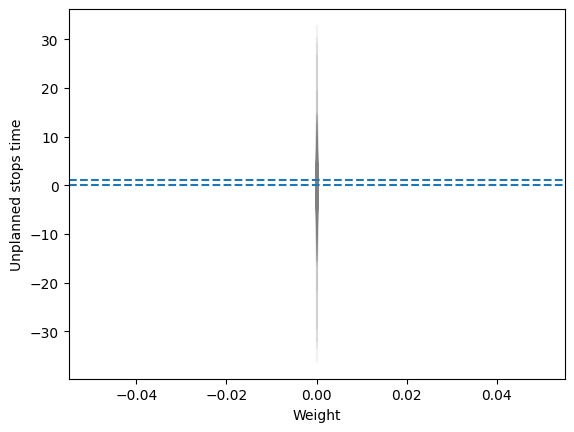

In [18]:
sim_pd = sim.draws_pd()
alpha_samples = sim_pd.alpha.values
beta_samples = sim_pd.beta_.values
gamma_samples = sim_pd.gamma_.values

for i in range(len(alpha_samples)):
    plt.plot(data_sim["weight_counters"], alpha_samples[i] + beta_samples[i] * data_sim["weight_counters"] + gamma_samples[i] * data_sim["weight_cycles"], color="gray", alpha=0.1)

plt.axhline(y=0, ls="--"), plt.axhline(y=1, ls="--")
plt.xlabel("Weight"), plt.ylabel("Unplanned stops time")
plt.show()

**Possible predicted heights are consistent with minum and maximum heights observed in nature.**

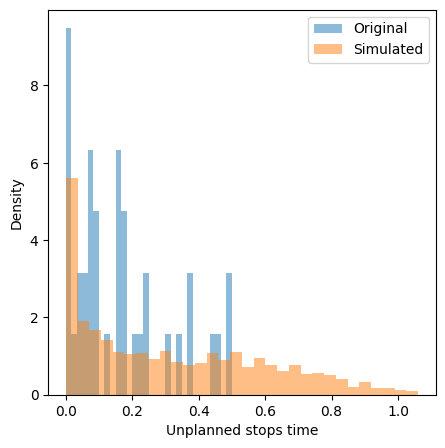

In [21]:
plt.figure(figsize=(5, 5))
plt.hist([v[2] for v in d.values()], bins=30, alpha=0.5, density=True, label="Original")
plt.hist(sim_pd["unplanned_stops_time[1]"], bins=30, alpha=0.5, density=True, label="Simulated")
plt.xlabel("Unplanned stops time"), plt.ylabel("Density")
plt.legend()
plt.show()

## Task 5. Fitting and evaluating model

In [25]:
model_2_fit = CmdStanModel(stan_file="unplanned_stops_linear_fit.stan")

ValueError: Failed to get source info for Stan model 'C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_fit.stan'. Console:
Warning in 'C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_fit.stan', line 3, column 2: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Warning in 'C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_fit.stan', line 33, column 4: Declaration
    of arrays by placing brackets after a variable name is deprecated and
    will be removed in Stan 2.33.0. Instead use the array keyword before the
    type. This can be changed automatically using the auto-format flag to
    stanc
Semantic error in 'C:\Users\gcyburt\Documents\repos\priv\AGH-Data-Analytics\Data-Analytics\Project\unplanned_stops_linear_fit.stan', line 29, column 40 to column 55:
   -------------------------------------------------
    27:  
    28:      // Likelihood
    29:      unplanned_stops_times ~ exponential(normal(mu, sig));
                                                 ^
    30:  }
    31:  
   -------------------------------------------------

A returning function was expected but an undeclared identifier 'normal' was supplied.
A similar known identifier is 'norm'


In [26]:
data_fit = {"N": len(d), "unplanned_stops_times": [v[2] for v in d.values()], "weight_counters": weight_counters, "weight_cycles": weight_cycles, "mu_mu": mu_mu, "mu_sig": mu_sig, "sig_lbd": sig_lbd}
fit = model_2_fit.sample(data=data_fit, seed=SEED)

NameError: name 'model_2_fit' is not defined

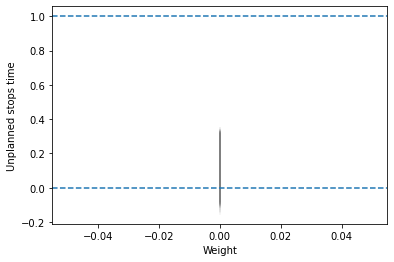

In [86]:
fit_pd = fit.draws_pd()
alpha_samples = fit_pd.alpha.values
beta_samples = fit_pd.beta_.values
gamma_samples = fit_pd.gamma_.values

for i in range(len(alpha_samples)):
    plt.plot(data_fit["weight_counters"], alpha_samples[i] + beta_samples[i] * data_fit["weight_counters"] + gamma_samples[i] * data_fit["weight_cycles"], color="gray", alpha=0.1)

plt.axhline(y=0, ls="--"), plt.axhline(y=1, ls="--")
plt.xlabel("Weight"), plt.ylabel("Unplanned stops time")
plt.show()

KeyError: 'unplanned_stops_time[1]'

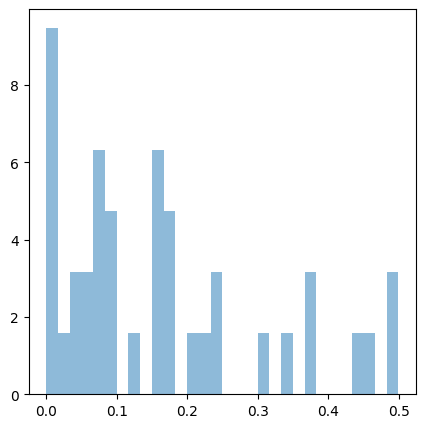

In [27]:
plt.figure(figsize=(5, 5))
plt.hist([v[2] for v in d.values()], bins=30, alpha=0.5, density=True, label="Original")
plt.hist(fit_pd["unplanned_stops_time[1]"], bins=30, alpha=0.5, density=True, label="Simulated")
plt.xlabel("Unplanned stops time"), plt.ylabel("Density")
plt.legend()
plt.show()

**The larger the number of samples $N$, the more narrow the uncertainty area.**

**Observed data is definitely possible within the posterior model. It is more accurate than the prior model - as expected.**

**The larger the number of samples $N$, the more narrow the error area.**